In [5]:
# Cell 1 — Notebook setup, imports, folders, config
# Run this first. It prepares the environment, creates folders, and prints a summary.

import os
import sys
import json
import random
from pathlib import Path
from datetime import datetime, timedelta, timezone

# Optional imports that we'll use later. If a package is missing, the cell will print the pip install line.
missing_packages = []
try:
    import numpy as np
except Exception:
    missing_packages.append("numpy")
try:
    import pandas as pd
except Exception:
    missing_packages.append("pandas")
try:
    from faker import Faker
except Exception:
    missing_packages.append("faker")
try:
    from tqdm import tqdm
except Exception:
    missing_packages.append("tqdm")
try:
    import matplotlib.pyplot as plt
except Exception:
    missing_packages.append("matplotlib")
try:
    import seaborn as sns
except Exception:
    missing_packages.append("seaborn")

# Print helpful message if packages are missing
if missing_packages:
    print("The following Python packages are missing (install to run full notebook):")
    for pkg in missing_packages:
        print(f"  - {pkg}")
    print("\nInstall them with pip, for example:")
    print("  pip install " + " ".join(missing_packages))
    print("\nYou can still run the setup portion; generation code will need these packages.\n")

# --- Configuration ---
# Virtual env name (for your local usage)
VENV_NAME = "user-behavior-env"

# 1. Fix: Point to the parent directory of 'notebooks'
BASE_DIR = Path.cwd().parent.resolve() 

# Now define the rest relative to that parent
NOTEBOOKS_DIR = BASE_DIR / "notebooks"
SRC_DIR = BASE_DIR / "src"
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
SRC_CONFIG_DIR = SRC_DIR / "config"
SRC_GENERATORS_DIR = SRC_DIR / "generators"
SRC_UTILS_DIR = SRC_DIR / "utils"
SRC_PIPELINE_DIR = SRC_DIR / "pipeline"
TESTS_DIR = BASE_DIR / "tests"

# Create folders if they don't exist
# (This logic was already correct, just the BASE_DIR was wrong)
for p in [
    BASE_DIR,
    NOTEBOOKS_DIR,
    SRC_DIR,
    SRC_CONFIG_DIR,
    SRC_GENERATORS_DIR,
    SRC_UTILS_DIR,
    SRC_PIPELINE_DIR,
    DATA_DIR,
    RAW_DIR,
    PROCESSED_DIR,
    TESTS_DIR,
]:
    p.mkdir(parents=True, exist_ok=True)

# Default generation settings (tunable)
SETTINGS = {
    "random_seed": 42,
    "num_users": 5000,
    "start_date": (datetime.now(timezone.utc) - timedelta(days=180)).strftime("%Y-%m-%dT%H:%M:%SZ"),
    "end_date": datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
    "avg_sessions_per_user": 5,
    "lambda_sessions_poisson": 3,   # used if you choose Poisson
    "avg_events_per_session": 8,
    "bot_ratio": 0.02,              # fraction of sessions that are bot-like
    "behavior_labels": ["explorer", "scanner", "buyer", "bot"],
    "page_types": ["home", "category", "product", "blog", "pricing", "checkout"],
    "device_types": ["mobile", "desktop", "tablet"],
    "traffic_sources": ["organic", "referral", "ads", "direct"],
    "output_files": {
        "users": str(RAW_DIR / "users_raw.csv"),
        "sessions": str(RAW_DIR / "sessions_raw.csv"),
        "events": str(RAW_DIR / "events_raw.csv"),
        "pages": str(RAW_DIR / "pages.csv"),
        "actions": str(RAW_DIR / "actions.csv"),
    }
}

# Save settings to src/config/settings.json for reuse
settings_path = SRC_CONFIG_DIR / "settings.json"
with open(settings_path, "w", encoding="utf-8") as f:
    json.dump(SETTINGS, f, indent=2)

# Seed randomness for reproducibility
random.seed(SETTINGS["random_seed"])
try:
    np.random.seed(SETTINGS["random_seed"])
except Exception:
    pass

# Helper: print a concise summary of setup
def print_setup_summary():
    print("=" * 60)
    print("Phase 1 — Synthetic Data Generator: Notebook Setup")
    print("=" * 60)
    print(f"Project root: {BASE_DIR}")
    print(f"Notebooks dir: {NOTEBOOKS_DIR}")
    print(f"Source dir: {SRC_DIR}")
    print(f"Raw data dir: {RAW_DIR}")
    print(f"Processed data dir: {PROCESSED_DIR}")
    print()
    print("Key generation settings:")
    for k in ["random_seed", "num_users", "start_date", "end_date", "avg_sessions_per_user", "avg_events_per_session", "bot_ratio"]:
        print(f"  - {k}: {SETTINGS[k]}")
    print()
    print("Output files (raw):")
    for name, path in SETTINGS["output_files"].items():
        print(f"  - {name}: {path}")
    print()
    print("NOTE: If required packages were missing, install them before running generation cells.")
    print("=" * 60)

print_setup_summary()

# Indicate readiness for next cell
"Setup complete — run the next cell to start generating synthetic users (I will give you the next cell after you paste the output of this cell)."


Phase 1 — Synthetic Data Generator: Notebook Setup
Project root: C:\Users\ASUS\Desktop\user_behavior_project
Notebooks dir: C:\Users\ASUS\Desktop\user_behavior_project\notebooks
Source dir: C:\Users\ASUS\Desktop\user_behavior_project\src
Raw data dir: C:\Users\ASUS\Desktop\user_behavior_project\data\raw
Processed data dir: C:\Users\ASUS\Desktop\user_behavior_project\data\processed

Key generation settings:
  - random_seed: 42
  - num_users: 5000
  - start_date: 2025-06-03T10:29:01Z
  - end_date: 2025-11-30T10:29:01Z
  - avg_sessions_per_user: 5
  - avg_events_per_session: 8
  - bot_ratio: 0.02

Output files (raw):
  - users: C:\Users\ASUS\Desktop\user_behavior_project\data\raw\users_raw.csv
  - sessions: C:\Users\ASUS\Desktop\user_behavior_project\data\raw\sessions_raw.csv
  - events: C:\Users\ASUS\Desktop\user_behavior_project\data\raw\events_raw.csv
  - pages: C:\Users\ASUS\Desktop\user_behavior_project\data\raw\pages.csv
  - actions: C:\Users\ASUS\Desktop\user_behavior_project\data\

'Setup complete — run the next cell to start generating synthetic users (I will give you the next cell after you paste the output of this cell).'

In [6]:
# Cell 2 — Generate Synthetic Users
import pandas as pd
from faker import Faker
import numpy as np
from datetime import datetime, timedelta
import json

# Load generation settings
settings_path = SRC_CONFIG_DIR / "settings.json"
with open(settings_path, "r", encoding="utf-8") as f:
    SETTINGS = json.load(f)

faker = Faker()
Faker.seed(SETTINGS["random_seed"])

num_users = SETTINGS["num_users"]
start_date = datetime.strptime(SETTINGS["start_date"], "%Y-%m-%dT%H:%M:%SZ")
end_date = datetime.strptime(SETTINGS["end_date"], "%Y-%m-%dT%H:%M:%SZ")

# Behavior distribution
behavior_labels = SETTINGS["behavior_labels"]
behavior_probs = [0.40, 0.30, 0.28, 0.02]  # explorer, scanner, buyer, bot

# Device distribution
device_types = SETTINGS["device_types"]
device_probs = [0.55, 0.35, 0.10]

# Traffic source distribution
traffic_sources = SETTINGS["traffic_sources"]
traffic_probs = [0.40, 0.25, 0.20, 0.15]

users = []
for i in range(num_users):
    acct_date = faker.date_time_between(start_date=start_date, end_date=end_date)

    users.append({
        "user_id": f"U{i+1:05d}",
        "name": faker.name(),
        "email": faker.email(),
        "country": faker.country(),
        "device_type": np.random.choice(device_types, p=device_probs),
        "traffic_source": np.random.choice(traffic_sources, p=traffic_probs),
        "behavior_label": np.random.choice(behavior_labels, p=behavior_probs),
        "account_created_at": acct_date.strftime("%Y-%m-%d %H:%M:%S")
    })

users_df = pd.DataFrame(users)

# Save output file
output_path = SETTINGS["output_files"]["users"]
users_df.to_csv(output_path, index=False)

print("Generated Users:", len(users_df))
users_df.head(10)


Generated Users: 5000


,user_id,name,email,country,device_type,traffic_source,behavior_label,account_created_at
0,U00001,Patrick Sanchez,jillrhodes@example.net,Benin,mobile,direct,buyer,2025-10-05 14:25:42
1,U00002,Allen Robinson,hoffmanjennifer@example.net,Mayotte,desktop,organic,explorer,2025-09-26 02:22:41
2,U00003,Kevin Pacheco,blakeerik@example.com,Guam,mobile,direct,scanner,2025-08-23 21:35:15
3,U00004,Tyler Rogers,jamesmichael@example.com,Netherlands,desktop,organic,buyer,2025-07-27 09:27:28
4,U00005,Monica Herrera,smiller@example.net,Niger,desktop,organic,explorer,2025-07-24 19:14:24
5,U00006,Laura Bush,stanleykendra@example.org,Timor-Leste,mobile,organic,scanner,2025-11-22 08:59:16
6,U00007,Jamie Chavez,francisco53@example.net,Ethiopia,mobile,organic,scanner,2025-07-18 15:22:03
7,U00008,Maria Lynch,amandasanchez@example.com,Hong Kong,mobile,organic,explorer,2025-10-17 17:12:11
8,U00009,Margaret Hawkins DDS,perezantonio@example.com,Iran,mobile,ads,explorer,2025-07-25 20:31:53
9,U00010,Thomas Bradley,jason76@example.net,Kuwait,mobile,referral,explorer,2025-07-25 10:14:47


In [7]:
# Cell 3 — Generate Pages & Actions Lookups
import pandas as pd
import json

# Load settings
with open(settings_path, "r", encoding="utf-8") as f:
    SETTINGS = json.load(f)

pages_output = SETTINGS["output_files"]["pages"]
actions_output = SETTINGS["output_files"]["actions"]

# ----------- Pages Lookup Table -----------
page_types = SETTINGS["page_types"]

pages_data = [
    {"page_id": "P001", "url_path": "/home", "page_type": "home", "avg_dwell_time_sec": 25},
    {"page_id": "P002", "url_path": "/category", "page_type": "category", "avg_dwell_time_sec": 40},
    {"page_id": "P003", "url_path": "/product", "page_type": "product", "avg_dwell_time_sec": 60},
    {"page_id": "P004", "url_path": "/blog", "page_type": "blog", "avg_dwell_time_sec": 35},
    {"page_id": "P005", "url_path": "/pricing", "page_type": "pricing", "avg_dwell_time_sec": 45},
    {"page_id": "P006", "url_path": "/checkout", "page_type": "checkout", "avg_dwell_time_sec": 30},
]

pages_df = pd.DataFrame(pages_data)
pages_df.to_csv(pages_output, index=False)

# ----------- Actions Lookup Table -----------
actions_data = [
    {"action_id": "A001", "action_type": "page_view", "description": "User viewed the page"},
    {"action_id": "A002", "action_type": "click", "description": "User clicked an element"},
    {"action_id": "A003", "action_type": "scroll", "description": "User scrolled on the page"},
    {"action_id": "A004", "action_type": "add_to_cart", "description": "User added item to cart"},
    {"action_id": "A005", "action_type": "purchase", "description": "User completed purchase"},
    {"action_id": "A006", "action_type": "exit", "description": "User left the session"},
]

actions_df = pd.DataFrame(actions_data)
actions_df.to_csv(actions_output, index=False)

print("Pages and actions lookup tables created.")
pages_df.head(), actions_df.head()

Pages and actions lookup tables created.


(  page_id   url_path page_type  avg_dwell_time_sec
 0    P001      /home      home                  25
 1    P002  /category  category                  40
 2    P003   /product   product                  60
 3    P004      /blog      blog                  35
 4    P005   /pricing   pricing                  45,
   action_id  action_type                description
 0      A001    page_view       User viewed the page
 1      A002        click    User clicked an element
 2      A003       scroll  User scrolled on the page
 3      A004  add_to_cart    User added item to cart
 4      A005     purchase    User completed purchase)

In [8]:
# Cell 4 — Generate Synthetic Sessions
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
import json

# Load settings
with open(settings_path, "r", encoding="utf-8") as f:
    SETTINGS = json.load(f)

start_date_obj = datetime.strptime(SETTINGS["start_date"], "%Y-%m-%dT%H:%M:%SZ")
end_date_obj = datetime.strptime(SETTINGS["end_date"], "%Y-%m-%dT%H:%M:%SZ")

users_df = pd.read_csv(SETTINGS["output_files"]["users"])
pages_df = pd.read_csv(SETTINGS["output_files"]["pages"])

avg_sessions_per_user = SETTINGS["avg_sessions_per_user"]
avg_events_per_session = SETTINGS["avg_events_per_session"]

# Behavior label influence on sessions
behavior_session_multiplier = {
    "explorer": 1.2,   # more sessions
    "scanner": 0.9,
    "buyer": 1.0,
    "bot": 3.5          # bots create many sessions
}

from faker import Faker
faker = Faker()

sessions = []
session_counter = 1

for _, user in users_df.iterrows():

    behavior = user["behavior_label"]
    multiplier = behavior_session_multiplier.get(behavior, 1.0)

    # Poisson distribution for session count
    num_sessions = max(1, int(np.random.poisson(avg_sessions_per_user * multiplier)))

    for _ in range(num_sessions):
        session_id = f"S{session_counter:06d}"
        session_counter += 1

        # --- FIX IS HERE ---
        # Use the datetime objects (start_date_obj) instead of SETTINGS["start_date"]
        start_time = faker.date_time_between(
            start_date=start_date_obj, 
            end_date=end_date_obj
        )
        # -------------------

        # Duration based on behavior
        if behavior == "explorer":
            duration = int(np.random.normal(300, 80))    # longer sessions
        elif behavior == "scanner":
            duration = int(np.random.normal(120, 40))
        elif behavior == "buyer":
            duration = int(np.random.normal(200, 60))
        else:  # bot
            duration = int(np.random.normal(20, 5))

        duration = max(5, duration)  # avoid zero/negative

        end_time = start_time + timedelta(seconds=duration)

        # Number of events
        num_events = max(1, int(np.random.poisson(avg_events_per_session)))

        # Entry & exit pages
        entry_page = random.choice(pages_df["page_id"].tolist())
        exit_page = random.choice(pages_df["page_id"].tolist())

        sessions.append({
            "session_id": session_id,
            "user_id": user["user_id"],
            "start_time": start_time.strftime("%Y-%m-%d %H:%M:%S"),
            "end_time": end_time.strftime("%Y-%m-%d %H:%M:%S"),
            "duration_sec": duration,
            "num_events": num_events,
            "entry_page": entry_page,
            "exit_page": exit_page,
            "device_type": user["device_type"],
            "traffic_source": user["traffic_source"],
            "behavior_label": behavior
        })

# Convert to DataFrame
sessions_df = pd.DataFrame(sessions)

# Save CSV
sessions_output = SETTINGS["output_files"]["sessions"]
sessions_df.to_csv(sessions_output, index=False)

print("Generated Sessions:", len(sessions_df))
sessions_df.head()


Generated Sessions: 27539


,session_id,user_id,start_time,end_time,duration_sec,num_events,entry_page,exit_page,device_type,traffic_source,behavior_label
0,S000001,U00001,2025-07-29 04:46:03,2025-07-29 04:48:40,157,6,P006,P001,mobile,direct,buyer
1,S000002,U00001,2025-11-19 07:16:20,2025-11-19 07:18:50,150,10,P001,P006,mobile,direct,buyer
2,S000003,U00001,2025-07-10 06:31:04,2025-07-10 06:34:02,178,10,P003,P002,mobile,direct,buyer
3,S000004,U00001,2025-08-26 01:35:39,2025-08-26 01:39:40,241,6,P002,P002,mobile,direct,buyer
4,S000005,U00002,2025-07-31 04:50:33,2025-07-31 04:55:27,294,5,P006,P001,desktop,organic,explorer


In [9]:
# Cell 5 — Generate Synthetic Events
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import json
from tqdm import tqdm

# Load settings and existing data
with open(settings_path, "r", encoding="utf-8") as f:
    SETTINGS = json.load(f)

sessions_df = pd.read_csv(SETTINGS["output_files"]["sessions"])
pages_df = pd.read_csv(SETTINGS["output_files"]["pages"])
actions_df = pd.read_csv(SETTINGS["output_files"]["actions"])

events = []
event_counter = 1

for _, session in tqdm(sessions_df.iterrows(), total=len(sessions_df), desc="Generating Events"):
    session_id = session["session_id"]
    user_id = session["user_id"]
    start_time = datetime.strptime(session["start_time"], "%Y-%m-%d %H:%M:%S")
    duration = session["duration_sec"]
    num_events = int(session["num_events"])
    behavior = session["behavior_label"]

    # Time per event (roughly evenly spread, add some randomness)
    if num_events > 1:
        time_deltas = np.diff(np.sort(np.random.uniform(0, duration, num_events)))
        time_deltas = np.insert(time_deltas, 0, 0)
    else:
        time_deltas = [0]

    prev_page = None

    for i in range(num_events):
        event_time = start_time + timedelta(seconds=int(time_deltas[i]))

        # Event type selection probabilities
        if i == num_events - 1:
            event_type = "exit"
        else:
            # More clicks/scrolls for explorers/buyers
            if behavior == "scanner":
                event_type = np.random.choice(["page_view", "click", "scroll"], p=[0.6,0.3,0.1])
            elif behavior == "explorer":
                event_type = np.random.choice(["page_view", "click", "scroll"], p=[0.3,0.5,0.2])
            elif behavior == "buyer":
                event_type = np.random.choice(["page_view", "click", "scroll", "add_to_cart", "purchase"], p=[0.3,0.4,0.2,0.05,0.05])
            else:  # bot
                event_type = np.random.choice(["page_view", "click", "scroll"], p=[0.2,0.7,0.1])

        # Page selection (stay on session entry/exit pages for first/last events)
        if i == 0:
            page_id = session["entry_page"]
        elif i == num_events - 1:
            page_id = session["exit_page"]
        else:
            page_id = random.choice(pages_df["page_id"].tolist())

        # Optional element_id
        element_id = f"el_{random.randint(1,20)}" if event_type in ["click", "add_to_cart", "purchase"] else None

        # time_on_page and scroll_depth
        time_on_page = np.random.uniform(1, min(60, duration / max(1, num_events))) if event_type != "exit" else 0
        scroll_depth = np.random.uniform(10, 100) if event_type == "scroll" else np.nan

        # Event value (for purchases)
        event_value = round(np.random.uniform(5, 200), 2) if event_type == "purchase" else np.nan

        # Referrer
        referrer = prev_page

        events.append({
            "event_id": f"E{event_counter:07d}",
            "session_id": session_id,
            "user_id": user_id,
            "timestamp": event_time.strftime("%Y-%m-%d %H:%M:%S"),
            "event_type": event_type,
            "page_id": page_id,
            "element_id": element_id,
            "time_on_page": round(time_on_page, 2),
            "scroll_depth": round(scroll_depth,2) if not np.isnan(scroll_depth) else "",
            "event_value": event_value,
            "referrer": referrer
        })

        prev_page = page_id
        event_counter += 1

# Convert to DataFrame
events_df = pd.DataFrame(events)

# Save CSV
events_output = SETTINGS["output_files"]["events"]
events_df.to_csv(events_output, index=False)

print("Generated Events:", len(events_df))
events_df.head(10)


Generating Events: 100%|██████████| 27539/27539 [00:08<00:00, 3224.24it/s]


Generated Events: 220600


,event_id,session_id,user_id,timestamp,event_type,page_id,element_id,time_on_page,scroll_depth,event_value,referrer
0,E0000001,S000001,U00001,2025-07-29 04:46:03,page_view,P006,None,10.15,,NaN,None
1,E0000002,S000001,U00001,2025-07-29 04:46:22,page_view,P001,None,8.67,,NaN,P006
2,E0000003,S000001,U00001,2025-07-29 04:46:24,click,P004,el_14,10.71,,NaN,P001
3,E0000004,S000001,U00001,2025-07-29 04:46:23,scroll,P006,None,24.84,17.67,NaN,P004
4,E0000005,S000001,U00001,2025-07-29 04:46:09,click,P003,el_11,18.63,,NaN,P006
5,E0000006,S000001,U00001,2025-07-29 04:46:43,exit,P001,None,0.00,,NaN,P003
6,E0000007,S000002,U00001,2025-11-19 07:16:20,add_to_cart,P001,el_18,10.91,,NaN,None
7,E0000008,S000002,U00001,2025-11-19 07:16:21,scroll,P005,None,10.34,40.95,NaN,P001
8,E0000009,S000002,U00001,2025-11-19 07:16:38,click,P002,el_5,3.57,,NaN,P005
9,E0000010,S000002,U00001,2025-11-19 07:16:24,click,P002,el_12,11.52,,NaN,P002


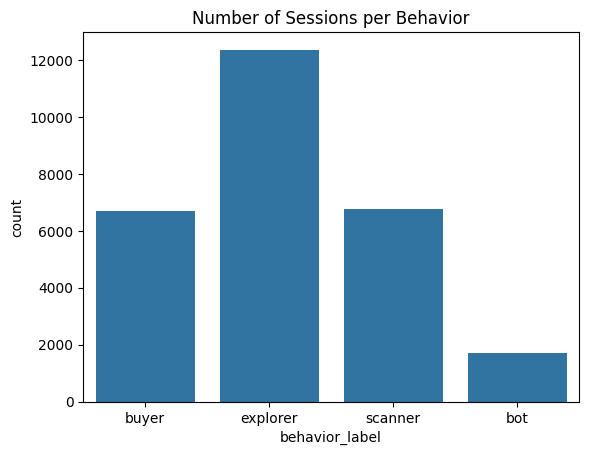

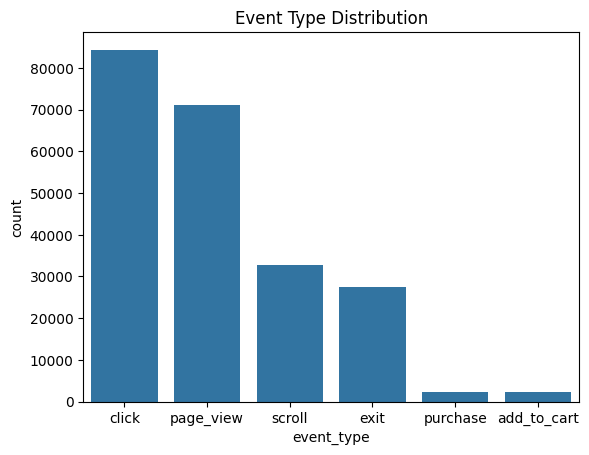

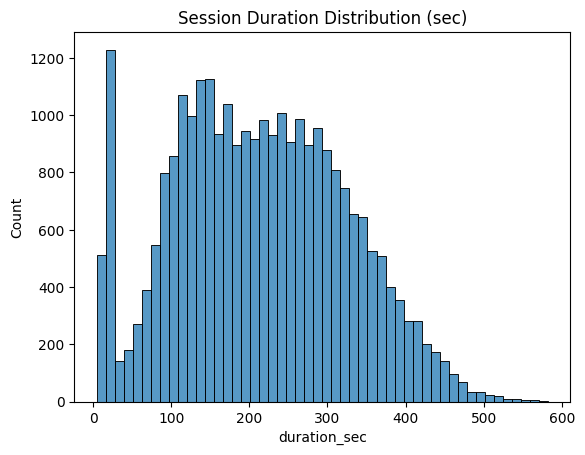

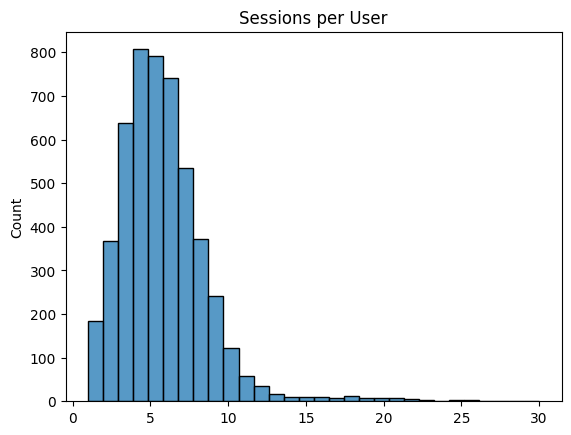

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Sessions per behavior
sns.countplot(data=sessions_df, x="behavior_label")
plt.title("Number of Sessions per Behavior")
plt.show()

# 2️⃣ Event types distribution
sns.countplot(data=events_df, x="event_type", order=events_df["event_type"].value_counts().index)
plt.title("Event Type Distribution")
plt.show()

# 3️⃣ Session duration histogram
sns.histplot(sessions_df["duration_sec"], bins=50)
plt.title("Session Duration Distribution (sec)")
plt.show()

# 4️⃣ Number of sessions per user
user_session_counts = sessions_df.groupby("user_id").size()
sns.histplot(user_session_counts, bins=30)
plt.title("Sessions per User")
plt.show()
